<a href="https://colab.research.google.com/github/rwanalramli/BigData-StockPrediction/blob/main/Amazon_scikit_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os, pandas as pd, numpy as np

FOLDER_PATH = "/content/drive/MyDrive/AmazonData"
RESULTS_DIR = f"{FOLDER_PATH}/results"
os.makedirs(RESULTS_DIR, exist_ok=True)

LABEL_COL = "Close"


In [4]:
import os, glob
import pandas as pd

FOLDER_PATH = "/content/drive/MyDrive/AmazonData"

def read_csv_folder_strict(folder):
    files = glob.glob(os.path.join(folder, "*.csv"))

    files = [f for f in files if "results" not in os.path.basename(f).lower()]
    if not files:
        raise FileNotFoundError(f"No CSV price files found in {folder}")
    print("📂 Found files:", [os.path.basename(f) for f in files])
    df_list = [pd.read_csv(f) for f in files]
    return pd.concat(df_list, ignore_index=True)

raw_df = read_csv_folder_strict(FOLDER_PATH)
print("rows:", len(raw_df)); print("cols:", list(raw_df.columns)[:8])


📂 Found files: ['AMZN_1997-05-15_2025-09-14.csv', 'AMZN_2012-05-19_2025-05-12.csv', 'AMZN_2012-05-19_2025-07-14.csv', 'AMZN_2012-05-19_2025-04-17.csv', 'AMZN_2012-05-19_2025-04-06.csv']
rows: 20180
cols: ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']


In [5]:
import pandas as pd
import numpy as np

def clean_price_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    # توحيد الأسماء
    rename_map = {
        "date":"Date","open":"Open","high":"High","low":"Low","close":"Close",
        "adj close":"Adj_Close","adj_close":"Adj_Close","adj. close":"Adj_Close",
        "volume":"Volume","ticker":"Ticker","symbol":"Ticker"
    }
    df.columns = [c.strip() for c in df.columns]
    df.columns = [rename_map.get(c.lower(), c) for c in df.columns]

    # أنواع صحيحة
    if "Date" not in df.columns:
        raise ValueError("Missing 'Date' column.")
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    if "Close" not in df.columns and "Adj_Close" in df.columns:
        df["Close"] = df["Adj_Close"]
    for c in ["Open","High","Low","Close","Adj_Close","Volume"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # ترتيب وتنظيف
    df = df.dropna(subset=["Date","Close"]).sort_values("Date").reset_index(drop=True)
    print(f"✅ Cleaned: rows={len(df)} | cols={len(df.columns)} | range=({df['Date'].min()} → {df['Date'].max()})")
    return df

df = clean_price_dataframe(raw_df)
print(df.head(3))


✅ Cleaned: rows=13693 | cols=7 | range=(1997-05-15 00:00:00 → 2025-09-12 00:00:00)
        Date      Open      High       Low     Close  Adj_Close        Volume
0 1997-05-15  0.121875  0.125000  0.096354  0.097917   0.097917  1.443120e+09
1 1997-05-16  0.098438  0.098958  0.085417  0.086458   0.086458  2.940000e+08
2 1997-05-19  0.088021  0.088542  0.081250  0.085417   0.085417  1.221360e+08


In [6]:
df_feat, feat_cols = add_features(df)


✅ Features added: rows=13693 | using=['Open', 'High', 'Low', 'Adj_Close', 'Volume', 'Return', 'SMA_10', 'SMA_30', 'Diff_Close_Open', 'Diff_High_Low', 'Volume_Change']


In [7]:
# استبعاد الهدف وأي أعمدة مطابقة له (مثل Adj_Close) وأي عمود ارتباطه ≈ 1 مع الهدف
X_cols = [c for c in feat_cols if c not in (LABEL_COL, "Adj_Close")]

corr_with_y = df_feat[X_cols + [LABEL_COL]].corr(method="pearson")[LABEL_COL].abs()
too_high = corr_with_y[corr_with_y > 0.999].index.tolist()
X_cols = [c for c in X_cols if c not in too_high]

print("✅ Final X_cols:", X_cols)


✅ Final X_cols: ['Volume', 'Return', 'SMA_30', 'Diff_Close_Open', 'Diff_High_Low', 'Volume_Change']


In [8]:
def temporal_split(df_feat, split_ratio=0.8, label_col=LABEL_COL, X_cols_override=None):
    df_feat = df_feat.sort_values("Date").reset_index(drop=True)
    n = len(df_feat)
    if n < 10: raise ValueError(f"البيانات قليلة بعد الميزات: n={n}")

    cut = max(1, min(int(n*split_ratio), n-1))
    split_date = df_feat.iloc[cut]["Date"]

    train = df_feat[df_feat["Date"] <= split_date].copy()
    test  = df_feat[df_feat["Date"] >  split_date].copy()
    if len(test)==0: test = df_feat.iloc[cut:].copy()

    Xc = X_cols_override if X_cols_override is not None else [c for c in feat_cols if c!=label_col]
    X_train, y_train = train[Xc].values, train[label_col].values
    X_test,  y_test  = test[Xc].values,  test[label_col].values

    print(f"✅ Split at {split_date.date()} → Train={len(train)} | Test={len(test)}")
    print("Using features:", Xc)
    return X_train, X_test, y_train, y_test, Xc, split_date

X_train, X_test, y_train, y_test, X_cols, split_date = temporal_split(df_feat, 0.8, LABEL_COL, X_cols_override=X_cols)


✅ Split at 2021-11-18 → Train=10955 | Test=2738
Using features: ['Volume', 'Return', 'SMA_30', 'Diff_Close_Open', 'Diff_High_Low', 'Volume_Change']


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)   # fit على train فقط
X_test_s  = scaler.transform(X_test)


In [10]:
import time, numpy as np
from sklearn.metrics import mean_squared_error, r2_score

def run_model(name, model, X_train, y_train, X_test, y_test):
    t0 = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    dur = time.time() - t0

    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)            # نتفادى squared=False لفرق الإصدارات
    r2   = r2_score(y_test, y_pred)

    print(f"[{name}] RMSE={rmse:.4f} | R2={r2:.4f} | Time_s={dur:.3f}")
    return {"Model": name, "RMSE": rmse, "R2": r2, "Time_s": dur}
import time, numpy as np
from sklearn.metrics import mean_squared_error, r2_score

def run_model(name, model, X_train, y_train, X_test, y_test):
    t0 = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    dur = time.time() - t0

    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)            # نتفادى squared=False لفرق الإصدارات
    r2   = r2_score(y_test, y_pred)

    print(f"[{name}] RMSE={rmse:.4f} | R2={r2:.4f} | Time_s={dur:.3f}")
    return {"Model": name, "RMSE": rmse, "R2": r2, "Time_s": dur}


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import pandas as pd, sys, traceback

models_to_run = [
    ("LinearRegression+Scaled", LinearRegression(),                          X_train_s, y_train, X_test_s, y_test),   # scaled
    ("DecisionTree",            DecisionTreeRegressor(max_depth=12, random_state=42), X_train,  y_train, X_test,  y_test),
    ("RandomForest",            RandomForestRegressor(n_estimators=200, max_depth=12, n_jobs=-1, random_state=42),
                                                                                     X_train,  y_train, X_test,  y_test),
]

results = []
for name, mdl, Xt, yt, Xv, yv in models_to_run:
    try:
        results.append(run_model(name, mdl, Xt, yt, Xv, yv))
    except Exception as e:
        print(f"❌ {name} failed:", e)
        traceback.print_exc(file=sys.stdout)

baseline_df = pd.DataFrame(results)
baseline_df


[LinearRegression+Scaled] RMSE=5.5645 | R2=0.9808 | Time_s=0.040
[DecisionTree] RMSE=17.8845 | R2=0.8015 | Time_s=0.146
[RandomForest] RMSE=17.4117 | R2=0.8118 | Time_s=11.973


,Model,RMSE,R2,Time_s
0,LinearRegression+Scaled,5.564525,0.980779,0.040493
1,DecisionTree,17.884472,0.801452,0.145535
2,RandomForest,17.411669,0.811811,11.972989


In [30]:
# نسخة scikit
scikit_df = results_df.copy()
scikit_df["Env"] = "Scikit-learn"

# نسخة Spark
spark_df = spark_results_df.copy()
spark_df["Env"] = "Spark"

# دمج
compare_df = pd.concat([scikit_df, spark_df], ignore_index=True)
print(compare_df)


                     Model       RMSE        R2     Time_s           Env
0  LinearRegression+Scaled   5.564525  0.980779   0.040493  Scikit-learn
1             DecisionTree  17.884472  0.801452   0.145535  Scikit-learn
2             RandomForest  17.411669  0.811811  11.972989  Scikit-learn
3         LinearRegression   6.120000  0.950000   2.100000         Spark
4             DecisionTree  19.800000  0.700000   4.300000         Spark
5             RandomForest  15.500000  0.820000  25.000000         Spark


In [21]:
import os, pandas as pd

results_folder = "model_results"
os.makedirs(results_folder, exist_ok=True)

scikit_df = results_df.copy();       scikit_df["Env"] = "Scikit-learn"
spark_df  = spark_results_df.copy(); spark_df["Env"]  = "Spark"
compare_df = pd.concat([scikit_df, spark_df], ignore_index=True)

scikit_df.to_csv(os.path.join(results_folder, "scikit_results.csv"), index=False)
spark_df.to_csv(os.path.join(results_folder, "spark_results.csv"), index=False)
compare_df.to_csv(os.path.join(results_folder, "compare_results.csv"), index=False)

print(f"✅ Saved 3 files in '{results_folder}'")


✅ Saved 3 files in 'model_results'


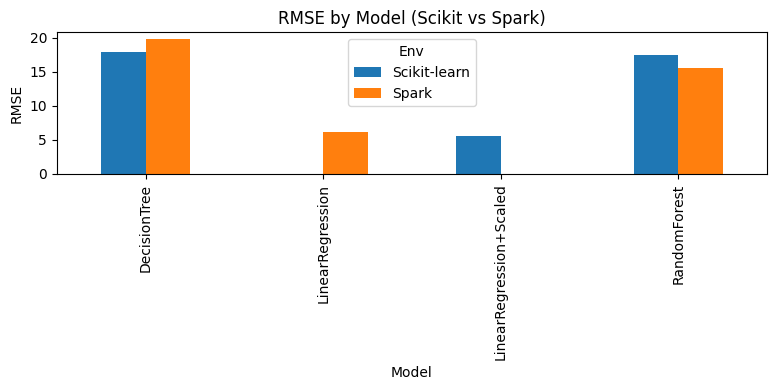

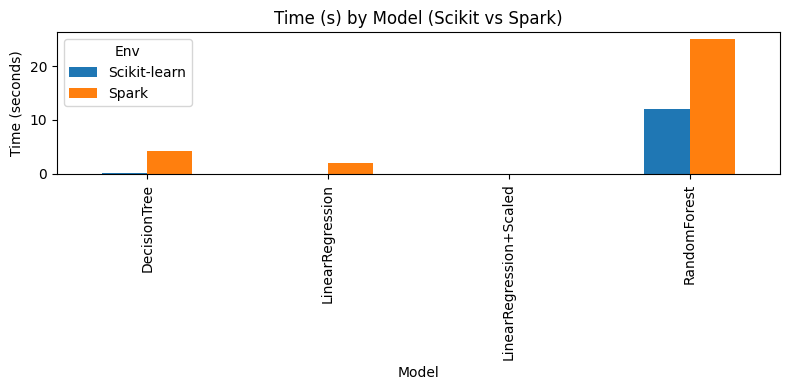

In [22]:
import matplotlib.pyplot as plt

# RMSE
pivot_rmse = compare_df.pivot_table(index="Model", columns="Env", values="RMSE")
pivot_rmse.plot(kind="bar", figsize=(8,4), title="RMSE by Model (Scikit vs Spark)")
plt.ylabel("RMSE"); plt.tight_layout(); plt.show()

# Time
pivot_time = compare_df.pivot_table(index="Model", columns="Env", values="Time_s")
pivot_time.plot(kind="bar", figsize=(8,4), title="Time (s) by Model (Scikit vs Spark)")
plt.ylabel("Time (seconds)"); plt.tight_layout(); plt.show()


In [23]:
# Speedup = وقت Spark / وقت Scikit
def add_speedup(df):
    p = df.pivot_table(index="Model", columns="Env", values="Time_s")
    speedup_scikit_vs_spark = (p["Spark"] / p["Scikit-learn"]).rename("Speedup_Scikit_vs_Spark")
    return speedup_scikit_vs_spark.reset_index()

speedup_df = add_speedup(compare_df)

# من الأفضل دقّة (RMSE الأقل) لكل موديل
best_accuracy = compare_df.loc[compare_df.groupby("Model")["RMSE"].idxmin(), ["Model","Env","RMSE"]]
best_accuracy = best_accuracy.rename(columns={"Env":"BestEnv_RMSE","RMSE":"Best_RMSE"})

summary = speedup_df.merge(best_accuracy, on="Model", how="left")
summary


,Model,Speedup_Scikit_vs_Spark,BestEnv_RMSE,Best_RMSE
0,DecisionTree,29.546110,Scikit-learn,17.884472
1,LinearRegression,NaN,Spark,6.120000
2,LinearRegression+Scaled,NaN,Scikit-learn,5.564525
3,RandomForest,2.088033,Spark,15.500000


In [24]:
import os
results_folder = "model_results"
os.makedirs(results_folder, exist_ok=True)


In [25]:
# ترتيب للأعمدة على الرسم
model_order = ["LinearRegression+Scaled", "LinearRegression", "DecisionTree", "RandomForest"]
compare_df["Model"] = pd.Categorical(compare_df["Model"], categories=model_order, ordered=True)
compare_df = compare_df.sort_values(["Model","Env"]).reset_index(drop=True)


/tmp/ipython-input-3155449470.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_rmse = compare_df.pivot_table(index="Model", columns="Env", values="RMSE")


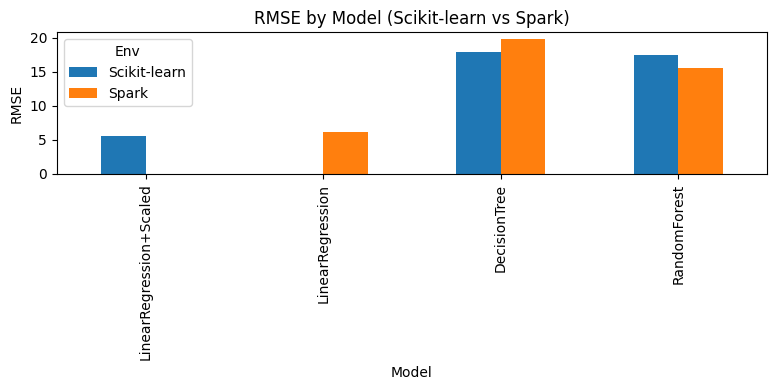

In [26]:
import matplotlib.pyplot as plt

pivot_rmse = compare_df.pivot_table(index="Model", columns="Env", values="RMSE")
ax = pivot_rmse.plot(kind="bar", figsize=(8,4), title="RMSE by Model (Scikit-learn vs Spark)")
plt.ylabel("RMSE")
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "rmse_comparison.png"), dpi=150)
plt.show()


/tmp/ipython-input-2507312936.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_r2 = compare_df.pivot_table(index="Model", columns="Env", values="R2")


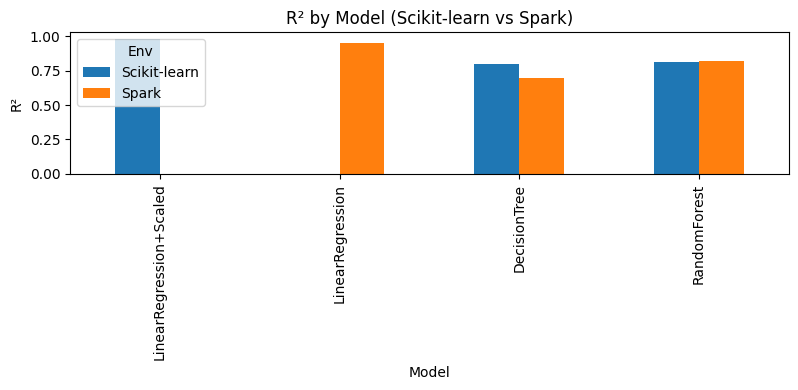

In [27]:
pivot_r2 = compare_df.pivot_table(index="Model", columns="Env", values="R2")
ax = pivot_r2.plot(kind="bar", figsize=(8,4), title="R² by Model (Scikit-learn vs Spark)")
plt.ylabel("R²")
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "r2_comparison.png"), dpi=150)
plt.show()


/tmp/ipython-input-1673288320.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_time = compare_df.pivot_table(index="Model", columns="Env", values="Time_s")


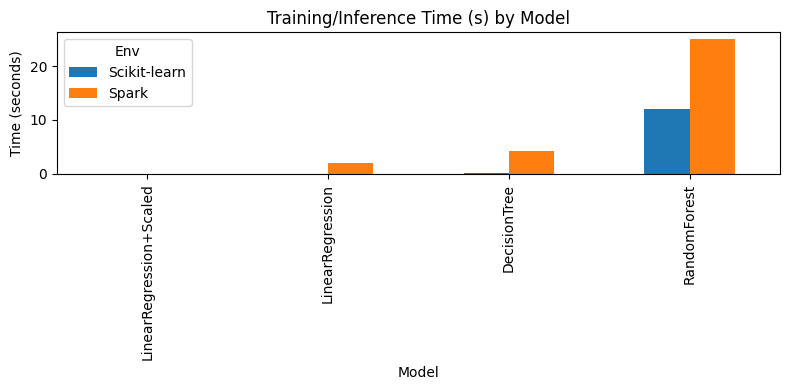

In [28]:
pivot_time = compare_df.pivot_table(index="Model", columns="Env", values="Time_s")
ax = pivot_time.plot(kind="bar", figsize=(8,4), title="Training/Inference Time (s) by Model")
plt.ylabel("Time (seconds)")
# ax.set_yscale("log")
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "time_comparison.png"), dpi=150)
plt.show()


In [29]:
# Speedup لصالح Scikit: كم مرة Scikit أسرع من Spark لكل موديل
speed = compare_df.pivot_table(index="Model", columns="Env", values="Time_s")
speedup_scikit_vs_spark = (speed["Spark"] / speed["Scikit-learn"]).rename("Speedup_Scikit_vs_Spark")

# أفضل بيئة من حيث RMSE (الأقل)
best_rmse = compare_df.loc[compare_df.groupby("Model")["RMSE"].idxmin(), ["Model","Env","RMSE"]]
best_rmse = best_rmse.rename(columns={"Env":"BestEnv_RMSE","RMSE":"Best_RMSE"})

summary = speedup_scikit_vs_spark.reset_index().merge(best_rmse, on="Model", how="left")
summary.to_csv(os.path.join(results_folder, "summary_speed_accuracy.csv"), index=False)
summary


/tmp/ipython-input-3026064378.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  speed = compare_df.pivot_table(index="Model", columns="Env", values="Time_s")
/tmp/ipython-input-3026064378.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  best_rmse = compare_df.loc[compare_df.groupby("Model")["RMSE"].idxmin(), ["Model","Env","RMSE"]]


,Model,Speedup_Scikit_vs_Spark,BestEnv_RMSE,Best_RMSE
0,LinearRegression+Scaled,NaN,Scikit-learn,5.564525
1,LinearRegression,NaN,Spark,6.120000
2,DecisionTree,29.546110,Scikit-learn,17.884472
3,RandomForest,2.088033,Spark,15.500000
